In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import brewer2mpl
import matplotlib.pyplot as plt
import pandas as pd
import prettyplotlib as ppl
import numpy as np
import scipy
import scipy.stats as stats
from astropy.modeling import models, fitting
from cycler import cycler
from scipy import signal
from scipy.optimize import curve_fit
from matplotlib import rc
set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)
rc('lines', linewidth=2)
rc('axes', prop_cycle=cycler('color', set2))

In [20]:
df = pd.read_csv('final_data_files/uncrowded_everything_m4_clipped.csv')
df_ab = df[df.type == 0]
df_c = df[df.type == 1]

df1 = df_c
if df1.type.any() == 0:
    dftype = 'ab'
    intrinsic_width = 0.035
else:
    dftype = 'c'
    intrinsic_width = 0.021

filt = '3'

if (filt == '4') & (dftype == 'ab'):
    intrinsic_width = 0.036

resid_finite = np.isfinite(df1.resid_m4_3.values)
resid3 = df1['resid_m4_' + filt].values[resid_finite]
merr3 = df1['merr_' + filt].values[resid_finite]

delta = 1e-4
big_grid = np.arange(-1,1,delta)
errscale = np.mean(merr3)
obsscale = np.std(resid3)

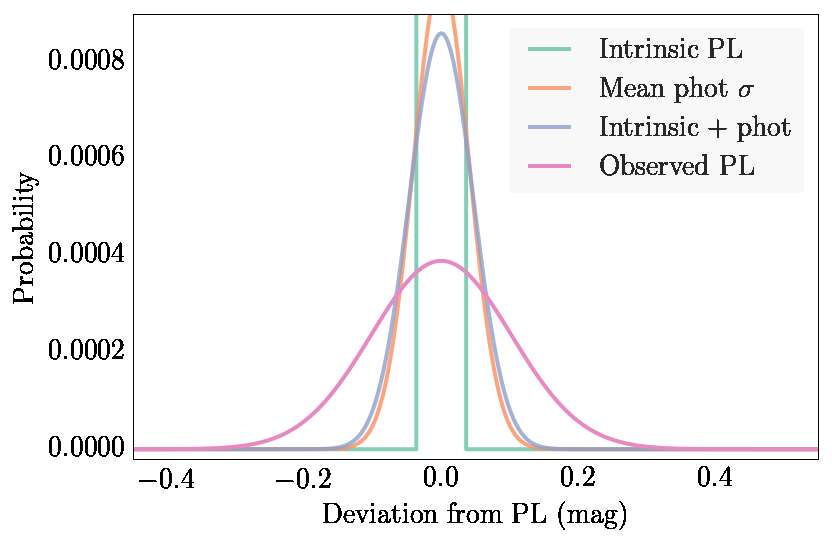

In [21]:
full_width_of_PL = np.sqrt(12.)*intrinsic_width
center_of_PL = -full_width_of_PL / 2
intrinsic = stats.uniform(loc=center_of_PL,scale=full_width_of_PL)
photometric = stats.norm(loc=0,scale=errscale)
observed = stats.norm(loc=0,scale=obsscale)

## Setting up the PDFs and PMFs for the components
pmf_i = intrinsic.pdf(big_grid)*delta
pmf_p = photometric.pdf(big_grid)*delta
pmf_o = observed.pdf(big_grid)*delta

#convolve 
conv_pmf = scipy.signal.fftconvolve(pmf_i,pmf_p,'same')
conv_pmf = conv_pmf/sum(conv_pmf)

fig = plt.figure()
ppl.plot(big_grid,pmf_i, label='Intrinsic PL', linewidth=2, alpha=0.8)
plt.plot(big_grid,pmf_p, label='Mean phot $\sigma$', alpha=0.8)
#plt.plot(big_grid,pmf_o, label='Observed PL', alpha=0.8)
plt.plot(big_grid,conv_pmf, label='Intrinsic + phot', alpha=0.8)
plt.plot(big_grid, pmf_o, label='Observed PL')
ppl.legend(prop={'size':14})
#plt.suptitle('Observed PL relation and known components')
ylim = np.array([-0.00002, 0.0009])
plt.ylim(ylim)
plt.xlim(-0.45,0.55)
plt.xlabel('Deviation from PL (mag)')
plt.ylabel('Probability')
fig.tight_layout()
fig.savefig('final_plots/distributions_nofeh_{}_{}_gaussian.pdf'.format(dftype, filt))

In [22]:
# so we divide big_grid by a scale factor to force the metallicity distribution
# to fit within the observed distribution
# this is essentially the same as changing the width of a gaussian
# i really can't explain rigorously why this works but it does

# this gets the pseudo-pdf for the rescaled metallicity distribution

def get_pmf_m(big_grid, stddev):
    mpdf = stats.norm(loc=0,scale=stddev)
    pmf_m = mpdf.pdf(big_grid)
    return pmf_m / sum(pmf_m)

In [23]:
# this convolves the metallicity distribution with the previous convolution
# of the intrinsic distribution and photometric errors

def get_convolved_m(big_grid, stddev):
    pmf_m = get_pmf_m(big_grid, stddev)
    metallicity_convolved = scipy.signal.fftconvolve(conv_pmf, pmf_m, 'same')
    metallicity_convolved = metallicity_convolved/sum(metallicity_convolved)
    return metallicity_convolved

In [24]:
# this may be the worst fitting a thing to a thing I have ever done
# optimize the scale factor on this shit

popt, pcov = curve_fit(get_convolved_m, big_grid, pmf_o, p0 = 0.1)
print 'Stddev of observed:', obsscale
print 'Stddev of phot errors:', errscale
print 'Stddev of metallicity:', popt[0]#, '$\pm$', np.sqrt(np.diag(pcov))[0]

Stddev of observed: 0.102368199291
Stddev of phot errors: 0.0409453923154
Stddev of metallicity: 0.0914197070466


In [25]:
pmf_m = get_pmf_m(big_grid, *popt)
metallicity_convolved = get_convolved_m(big_grid, *popt)

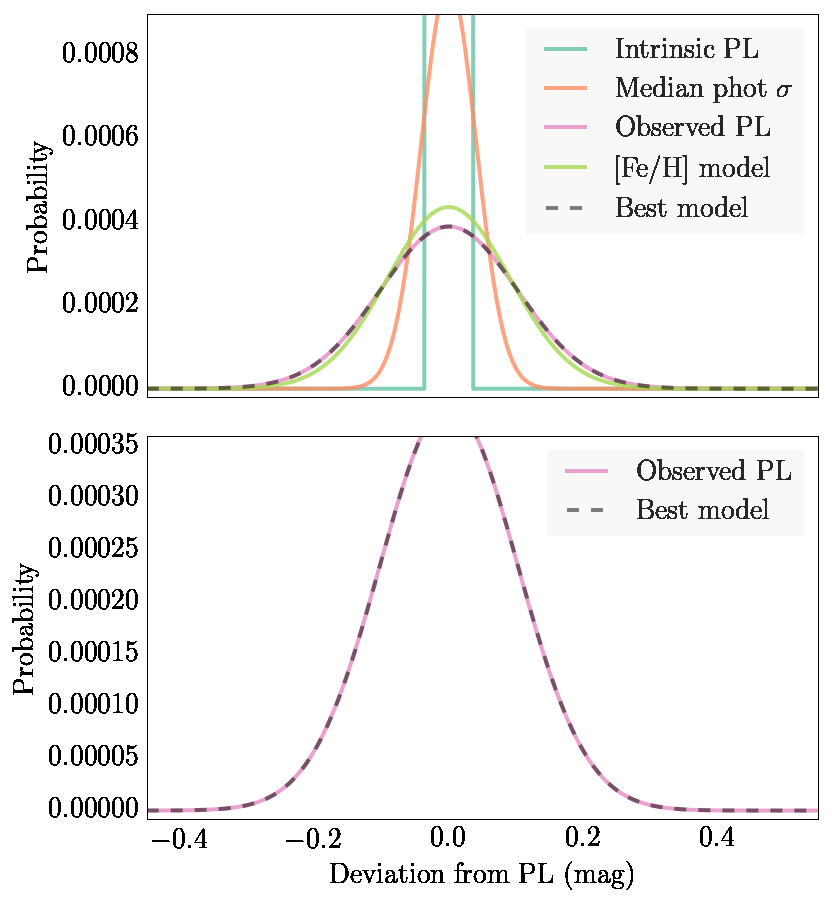

In [26]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,6.5), sharex=True)

ppl.plot(ax1, big_grid,pmf_i, label='Intrinsic PL', linewidth=2, alpha=0.8)
ax1.plot(big_grid,pmf_p, label='Median phot $\sigma$', alpha=0.8)
#ax1.plot(big_grid,pmf_o, label='Observed PL', alpha=0.8)
ax1.plot(big_grid,conv_pmf, alpha=0.)
ax1.plot(big_grid,pmf_o, label='Observed PL', alpha=0.8)
ax1.plot(big_grid,pmf_m, label="[Fe/H] model", alpha=0.8)
ax1.plot(big_grid,metallicity_convolved, label="Best model", linestyle='--',
         color='k', alpha=0.5)

ppl.plot(ax2, big_grid,pmf_o, label='Observed PL',
         color=set2[3], linewidth=2, alpha=0.8)
ax2.plot(big_grid,metallicity_convolved, label="Best model", linestyle='--',
         color='k', alpha=0.5)

ax2.set_xlabel('Deviation from PL (mag)')
ax1.set_ylabel('Probability')
ax2.set_ylabel('Probability')

#title_text = 'Best fit metallicity model, scale factor = {:.3f}'.format(popt[0])
ppl.legend(ax1, loc='best', prop={'size':14})
ppl.legend(ax2, loc='best', prop={'size':14})
#plt.suptitle(title_text)

ax1.set_xlim(-0.45,0.55)
ax1.set_ylim(ylim)
ax2.set_ylim(ylim * np.max(pmf_o) / np.max(pmf_p))
fig.tight_layout()
fig.savefig('final_plots/distributions_{}_{}_gaussian.pdf'.format(dftype, filt))

In [27]:
spect = df1.spectfeh[np.isfinite(df1.spectfeh) & resid_finite]
phot = df1.photfeh[np.isfinite(df1.photfeh) & resid_finite]
print (popt[0] / np.std(spect))
print (popt[0] / np.std(phot))

0.778216226635
0.323172591968


In [28]:
print np.sqrt(errscale**2 + popt[0]**2 + full_width_of_PL**2) - obsscale

0.0214303790062
